In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
file = 'lic-data-2016.csv'
nrows =-1 # to avoid loading full file each time
if nrows != -1 :
    data = pd.read_csv(file, sep=';', nrows=nrows, encoding='latin_1', dtype={'code_commune': str})
else:
     data= pd.read_csv(file, sep=';', encoding='latin_1', dtype={'code_commune': str})


In [3]:
# there is a need to add leading zero for couple of cities, in order to be able to merge wiht the geodata later on
data['code_commune'] = data['code_commune'].apply('{:0>5}'.format)

In [4]:
# Paragliding is about "vol libre" federation which is coded 258 in colmun 'fed_2016',
# according to file federation-2016.xlsx
# let's keep only that federation
data = data[data['fed_2016'].isin(['258'])]

In [5]:
data.shape

(7829, 68)

In [6]:
# load jsonfile to draw with geopandas later on
jsonfile = 'communes-20190101.json'
map_df = gpd.read_file(jsonfile)

In [7]:
map_df.columns

Index(['insee', 'nom', 'wikipedia', 'surf_ha', 'geometry'], dtype='object')

In [8]:
# need to rename the code_commune in order to merge both dataset on the common column
col_names = data.columns.values
col_names[0] = 'insee'
data.columns = col_names

In [9]:
# merging both dataset
merged = map_df.merge(data, on='insee')

In [10]:
# removing the non metropolitan cities
merged = merged[~merged.insee.str.contains('97[0-9]{3}')]#.value_counts()

In [11]:
# need to add some Region and Department info with a 3rd dataset
regdep=pd.read_csv('data.csv', sep=';', dtype={'CODGEO': str})

C:\Users\piersjea\AppData\Local\Continuum\anaconda3\envs\blog\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
regdep=regdep[['CODGEO','REG','DEP']]

In [13]:
# need to rename the CODGEO in order to merge dataset
col_names = regdep.columns.values
col_names[0] = 'insee'
regdep.columns = col_names

In [14]:
all_data = merged.merge(regdep, on='insee')

In [15]:
by_region = all_data.groupby(by='REG')

In [16]:
by_region['l_2016'].value_counts()

REG  l_2016
11   1         186
     2         100
     3          73
     4          38
     5          28
              ... 
94   6           2
     9           2
     4           1
     7           1
     24          1
Name: l_2016, Length: 317, dtype: int64

In [17]:
temp = all_data[['l_2016','REG']]
temp = temp[temp['REG'].isin(['94'])]
temp['l_2016'].sum()

148

In [18]:
24+7+4+9*2+6*2+3*4+2*17+37


148

In [19]:
by_region = all_data[['l_2016','REG']].groupby(by='REG').sum()
by_region['l_2016'].value_counts()

2367    1
7933    1
924     1
980     1
3859    1
338     1
3684    1
2349    1
769     1
1192    1
148     1
1828    1
1121    1
Name: l_2016, dtype: int64

In [20]:
by_department = all_data[['l_2016','DEP']].groupby(by='DEP').sum()

In [21]:
by_department['l_2016'].value_counts()

52      4
381     2
312     2
32      2
307     2
       ..
2130    1
1952    1
239     1
248     1
384     1
Name: l_2016, Length: 89, dtype: int64

In [22]:
# now, this is time to explore the data and extract some insights
# let's start with basic number of licensee and split by gender

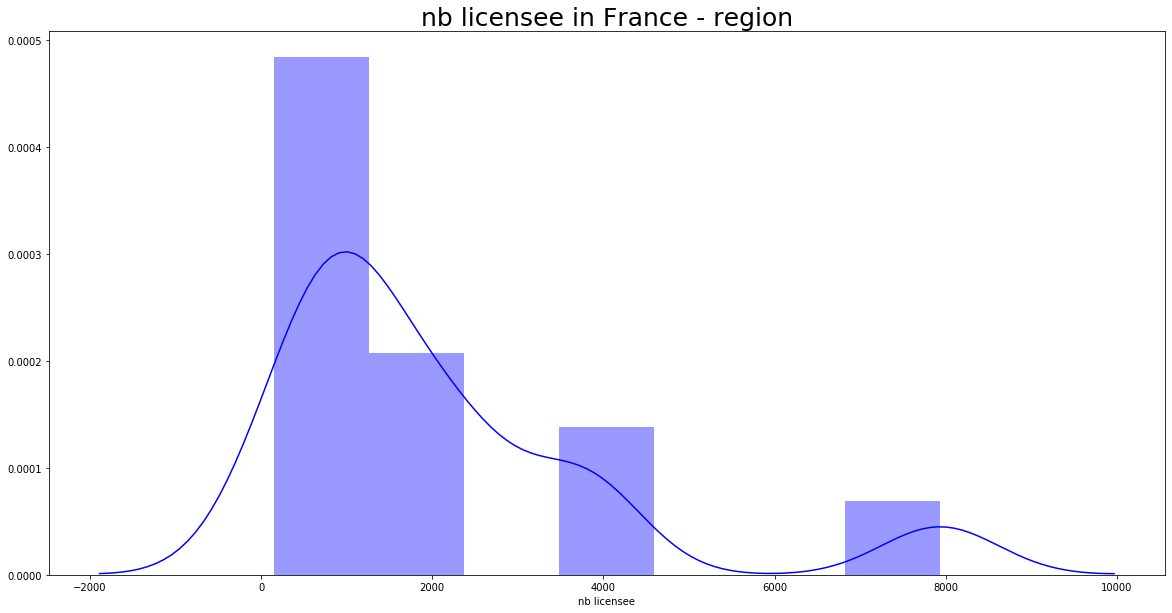

In [23]:
fig=plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)
sns.distplot(by_region['l_2016'],ax=ax1,hist=True,color='b',axlabel='nb licensee').set_title('nb licensee in France - region',fontsize=25);

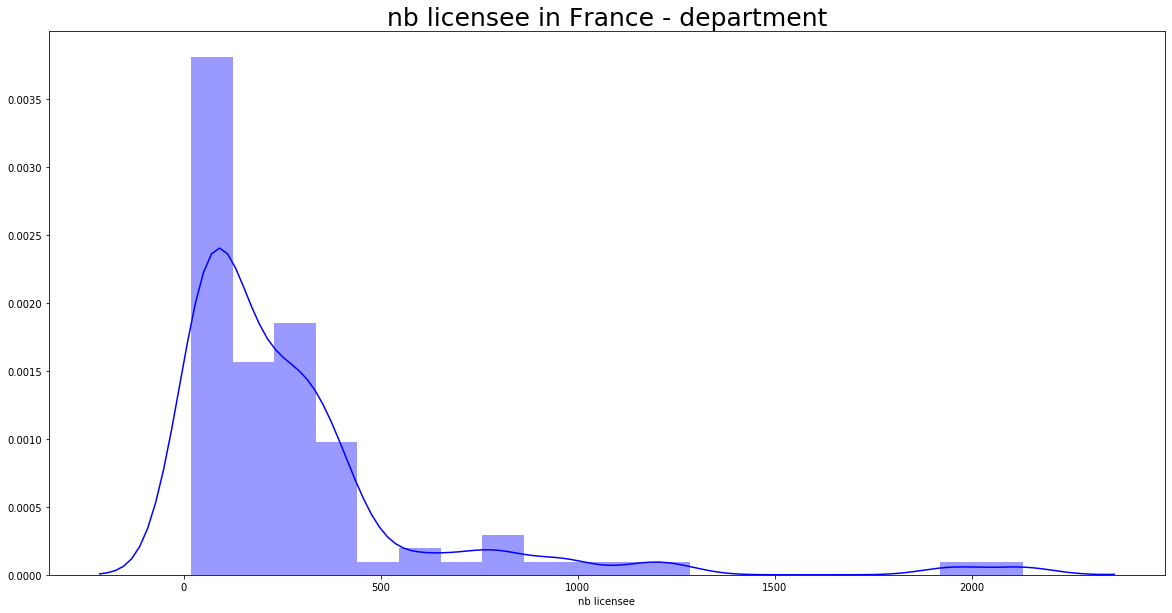

In [24]:
fig=plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)
sns.distplot(by_department['l_2016'],ax=ax1,hist=True,color='b',axlabel='nb licensee').set_title('nb licensee in France - department',fontsize=25);

In [25]:
all_data[all_data['nom']=='Haguenau']

,insee,nom,wikipedia,surf_ha,geometry,libelle,region,fed_2016,nom_fed,l_2016,...,poph_5_9_2015,poph_10_14_2015,poph_15_19_2015,poph_20_29_2015,poph_30_44_2015,poph_45_59_2015,poph_60_74_2015,poph_75_2015,REG,DEP
7335,67180,Haguenau,fr:Haguenau,18354,"POLYGON ((7.640494199999997 48.86143209972667,...",Haguenau,Grand Est,258,Fédération française de vol libre,3,...,1013,977,1162,2705,3375,3620,2337,1002,44,67


In [26]:
# by age ?

In [27]:
by_age_columns = ['l_0_4_2016', 
                  'l_5_9_2016', 
                  'l_10_14_2016', 
                  'l_15_19_2016', 
                  'l_20_29_2016', 
                  'l_30_44_2016', 
                  'l_45_59_2016', 
                  'l_60_74_2016']

In [28]:
by_age = pd.DataFrame(all_data, columns=by_age_columns)

In [29]:
# to be consistant and have columns of 15y each, there is a need to add some of the first coumns.
by_age['l_0_14_2016'] = by_age['l_0_4_2016']+by_age['l_5_9_2016']+by_age['l_10_14_2016']
by_age['l_15_29_2016'] = by_age['l_15_19_2016']+by_age['l_20_29_2016']
by_age.drop(columns=['l_0_4_2016','l_5_9_2016','l_10_14_2016','l_15_19_2016','l_20_29_2016'], inplace=True)

In [30]:
#by_age = pd.DataFrame(by_age.sum())
by_age = by_age.sum()
by_age

l_30_44_2016    9916
l_45_59_2016    8195
l_60_74_2016    2760
l_0_14_2016     1222
l_15_29_2016    5259
dtype: int64

In [31]:
by_age.index

Index(['l_30_44_2016', 'l_45_59_2016', 'l_60_74_2016', 'l_0_14_2016',
       'l_15_29_2016'],
      dtype='object')

In [32]:
new_index_age = {'l_0_14_2016':'0 to 14y',
                 'l_15_29_2016':'15 to 29y',
                 'l_30_44_2016':'30 to 44y',
                 'l_45_59_2016':'45 to 59y',
                 'l_60_74_2016':'60 to 74y'
                }


In [33]:
by_age

l_30_44_2016    9916
l_45_59_2016    8195
l_60_74_2016    2760
l_0_14_2016     1222
l_15_29_2016    5259
dtype: int64

In [34]:
by_age.sort_index(inplace=True)

In [35]:
#by_age.rename(new_index_age, inplace=True)
by_age.rename(new_index_age, inplace=True)

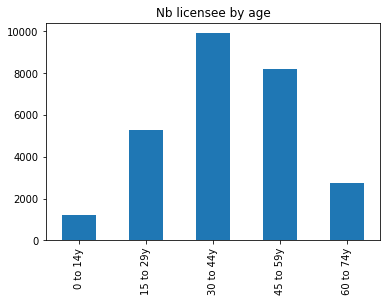

In [36]:
by_age.plot.bar(title='Nb licensee by age')

In [37]:
#by gender

In [38]:
by_gender = all_data[['l_f_2016','l_h_2016']].sum()

In [39]:
new_index_gender = {'l_f_2016':'female',
                    'l_h_2016':'male'}

In [40]:
by_gender.rename(new_index_gender, inplace=True)

In [41]:
my_colors = ['violet','darkblue']

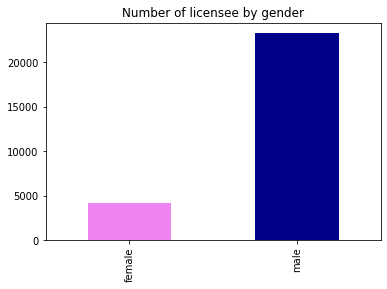

In [42]:
by_gender.plot.bar(color=my_colors,title='Number of licensee by gender')

In [43]:
# by age and by gender ?

In [44]:
by_age_gender_h_columns = ['l_0_4_h_2016', 
                           'l_5_9_h_2016', 
                           'l_10_14_h_2016', 
                           'l_15_19_h_2016', 
                           'l_20_29_h_2016', 
                           'l_30_44_h_2016', 
                           'l_45_59_h_2016', 
                           'l_60_74_h_2016']


In [45]:
by_age_gender_f_columns = ['l_0_4_f_2016', 
                           'l_5_9_f_2016', 
                           'l_10_14_f_2016', 
                           'l_15_19_f_2016', 
                           'l_20_29_f_2016', 
                           'l_30_44_f_2016', 
                           'l_45_59_f_2016', 
                           'l_60_74_f_2016']

In [46]:
by_age_gender_h = pd.DataFrame(all_data, columns=by_age_gender_h_columns)
by_age_gender_f = pd.DataFrame(all_data, columns=by_age_gender_f_columns)

In [47]:
by_age_gender_h['l_0_14_h_2016'] = by_age_gender_h['l_0_4_h_2016']+by_age_gender_h['l_5_9_h_2016']+by_age_gender_h['l_10_14_h_2016']
by_age_gender_h['l_15_29_h_2016'] = by_age_gender_h['l_15_19_h_2016']+by_age_gender_h['l_20_29_h_2016']
by_age_gender_h.drop(columns=['l_0_4_h_2016','l_5_9_h_2016','l_10_14_h_2016','l_15_19_h_2016','l_20_29_h_2016'], inplace=True)

In [48]:
by_age_gender_f['l_0_14_f_2016'] = by_age_gender_f['l_0_4_f_2016']+by_age_gender_f['l_5_9_f_2016']+by_age_gender_f['l_10_14_f_2016']
by_age_gender_f['l_15_29_f_2016'] = by_age_gender_f['l_15_19_f_2016']+by_age_gender_f['l_20_29_f_2016']
by_age_gender_f.drop(columns=['l_0_4_f_2016','l_5_9_f_2016','l_10_14_f_2016','l_15_19_f_2016','l_20_29_f_2016'], inplace=True)

In [49]:
by_age_gender_h = by_age_gender_h.sum()
by_age_gender_f = by_age_gender_f.sum()

In [50]:
by_age_gender_h.sort_index(inplace=True)
by_age_gender_f.sort_index(inplace=True)

new_index_age_gender_h = {'l_0_14_h_2016':'0 to 14y',
                          'l_15_29_h_2016':'15 to 29y',
                          'l_30_44_h_2016':'30 to 44y',
                          'l_45_59_h_2016':'45 to 59y',
                          'l_60_74_h_2016':'60 to 74y'}

new_index_age_gender_f = {'l_0_14_f_2016':'0 to 14y',
                          'l_15_29_f_2016':'15 to 29y',
                          'l_30_44_f_2016':'30 to 44y',
                          'l_45_59_f_2016':'45 to 59y',
                          'l_60_74_f_2016':'60 to 74y'}

by_age_gender_h.rename(new_index_age_gender_h, inplace=True)
by_age_gender_f.rename(new_index_age_gender_f, inplace=True)

In [51]:
by_age_gender_h = pd.DataFrame(by_age_gender_h)
by_age_gender_h['gender'] = 'M'

by_age_gender_f = pd.DataFrame(by_age_gender_f)
by_age_gender_f['gender'] = 'F'

In [52]:
by_age_gender = pd.concat([by_age_gender_h, by_age_gender_f])
by_age_gender['age'] = by_age_gender.index

In [53]:
columns = by_age_gender.columns.values
columns[0] = 'nb'
by_age_gender.columns = columns

In [54]:
by_age_gender

,nb,gender,age
0 to 14y,727,M,0 to 14y
15 to 29y,3879,M,15 to 29y
30 to 44y,8441,M,30 to 44y
45 to 59y,7488,M,45 to 59y
60 to 74y,2604,M,60 to 74y
0 to 14y,495,F,0 to 14y
15 to 29y,1380,F,15 to 29y
30 to 44y,1475,F,30 to 44y
45 to 59y,707,F,45 to 59y
60 to 74y,156,F,60 to 74y


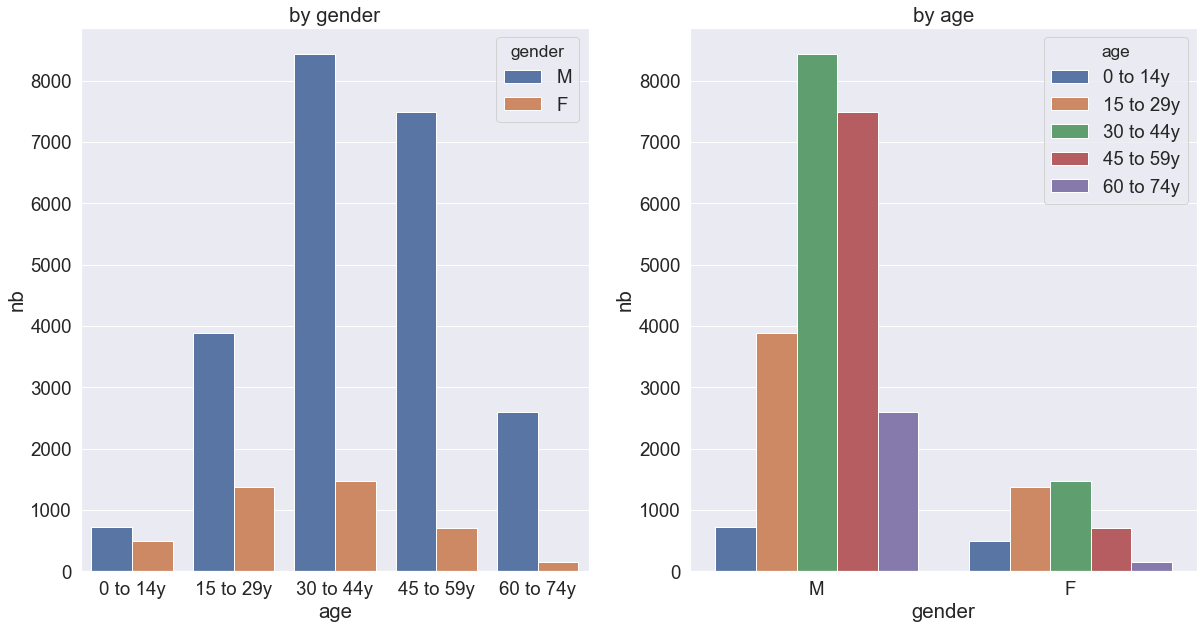

In [55]:
fig=plt.figure(figsize=(20,10))
sns.set(font_scale=1.7)
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('by gender')
sns.barplot(x="age", y="nb",hue="gender", data=by_age_gender,ax=ax1)

ax2 = fig.add_subplot(1,2,2)
ax2.set_title('by age')
sns.barplot(x="gender", y="nb",hue="age", data=by_age_gender,ax=ax2)

In [56]:
# top 10 cities in terms of number of licensee
top_10 = all_data.sort_values(by='l_2016', ascending=False)
top_10 = top_10[:10]

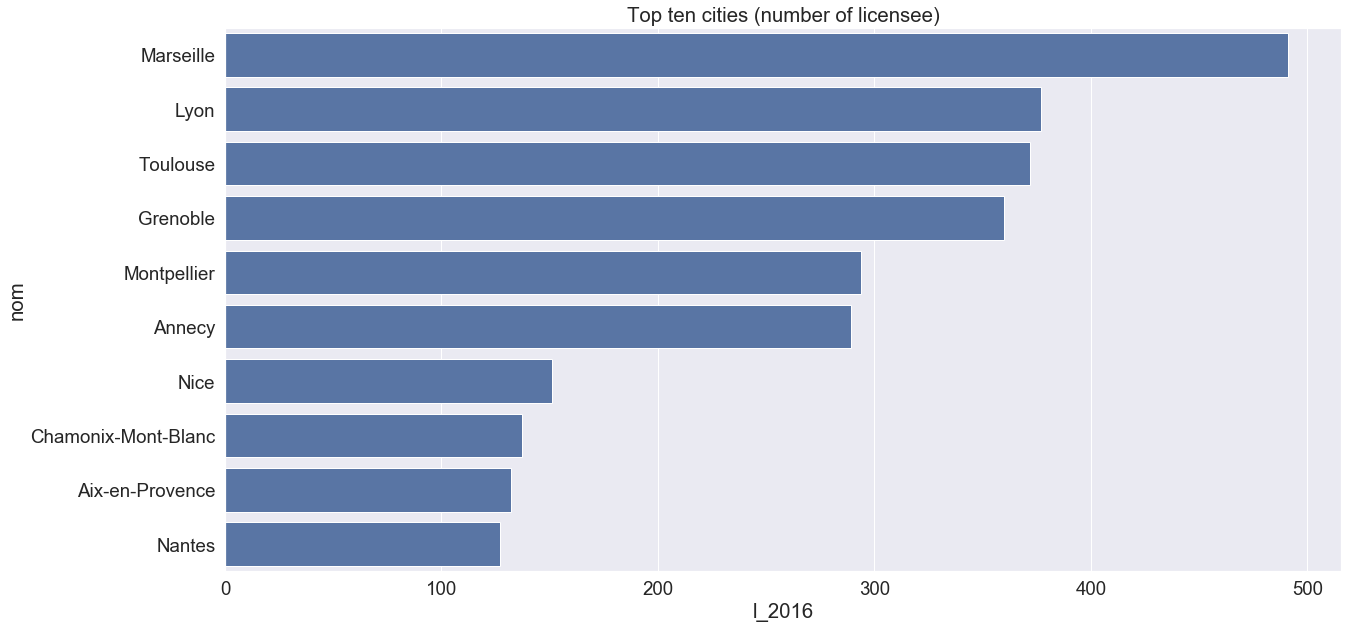

In [57]:
fig = plt.figure(figsize=(20,10))
plt.title('Top ten cities (number of licensee)')
sns.set(font_scale=2)
snsbp = sns.barplot(data=top_10,y='nom',x='l_2016',color='b',capsize=0.5);
snsbp.set_xticklabels(snsbp.get_xticklabels(), rotation=90,minor=True);

In [58]:
# create a function to plot on the map
def plot_column(mydata, columnname, maptitle, color=plt.cm.Blues):
    vmin, vmax = int(np.min(mydata[columnname])), int(np.max(mydata[columnname]))
    fig, ax = plt.subplots(1, figsize=(20, 10))
    mydata.plot(column=columnname, cmap=color, ax=ax, scheme='Quantiles', legend=True, k=5) #plt.cm.plasma 'OrRd'
    ax.set_title(maptitle, fontsize=1)

C:\Users\piersjea\AppData\Local\Continuum\anaconda3\envs\blog\lib\site-packages\mapclassify\classifiers.py:95: UserWarning: Warning: Not enough unique values in array to form k classes
  UserWarning)
C:\Users\piersjea\AppData\Local\Continuum\anaconda3\envs\blog\lib\site-packages\mapclassify\classifiers.py:96: UserWarning: Warning: setting k to 4
  Warn('Warning: setting k to %d' % k_q, UserWarning)


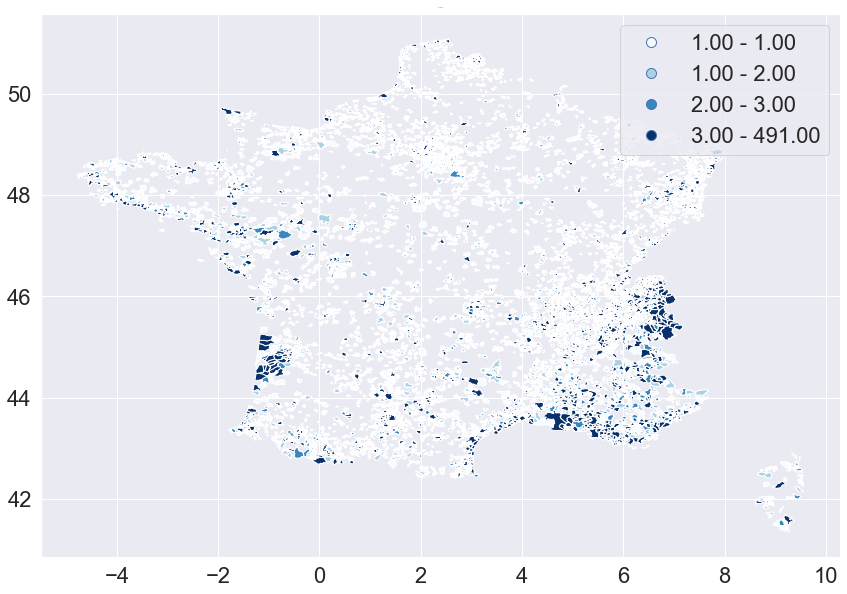

In [59]:
plot_column(all_data, 'l_2016','nb licencee')

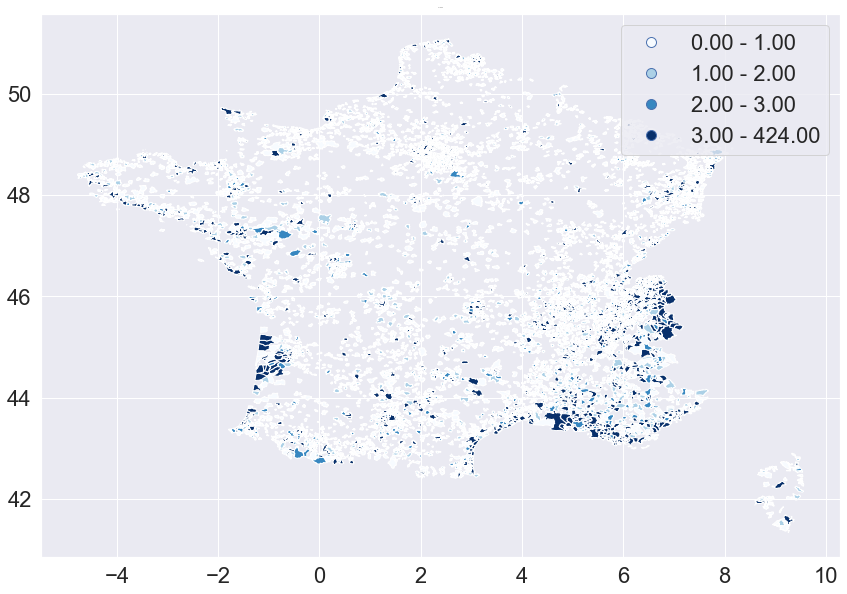

In [60]:
plot_column(all_data, 'l_h_2016','nb licencee')